In [48]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy.io.wavfile as wavfile
import scipy.signal as signal

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras import layers, models

In [49]:
FILE_PATH = './donateacry_corpus'
dataset = pathlib.Path(FILE_PATH)
cry_list = np.array(tf.io.gfile.listdir(str(dataset)))
print(cry_list) 

['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']


In [50]:
train_set, val_set = tf.keras.utils.audio_dataset_from_directory(
    directory=FILE_PATH,
    batch_size=16,
    seed=0,
    validation_split=.2,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_set.class_names)
print(label_names)
print(len(train_set))
print(len(val_set))

Found 457 files belonging to 5 classes.
Using 366 files for training.
Using 91 files for validation.
['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']
23
6


In [51]:
def squeeze(audio, label):
    audio=tf.squeeze(audio, axis=-1)
    return audio, label

train_set = train_set.map(squeeze, tf.data.AUTOTUNE)
val_set = val_set.map(squeeze, tf.data.AUTOTUNE)

test_set = val_set.shard(num_shards=2, index=0)
val_set = val_set.shard(num_shards=2, index=1)

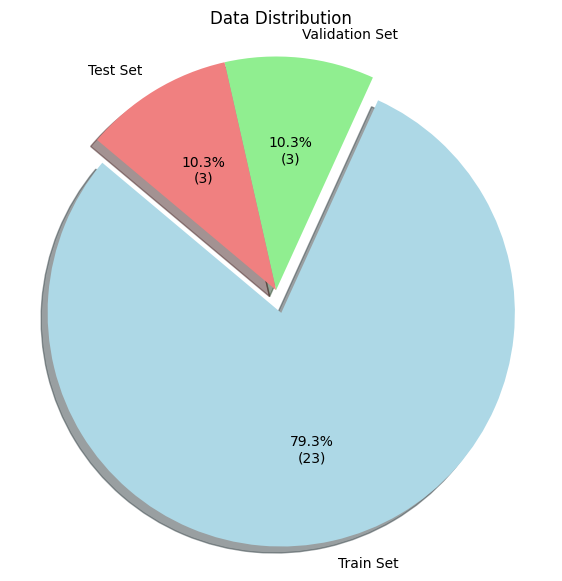

In [52]:
train_samples = len(list(train_set))
val_samples = len(list(val_set))
test_samples = len(list(test_set))

labels = ['Train Set', 'Validation Set', 'Test Set']
sizes = [train_samples, val_samples, test_samples]
colors = ['lightblue', 'lightgreen', 'lightcoral']
explode = (0.1, 0, 0) 

def autopct_format(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda pct: autopct_format(pct, sizes), shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Distribution')
plt.show()

In [53]:
def get_spectogram(waveform):
    spectogram=tf.signal.stft(
        signals=waveform,
        frame_length=255,
        frame_step=128
    )
    spectogram=tf.abs(spectogram)
    spectogram=spectogram[..., tf.newaxis]
    return spectogram

def make_spectogram_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [54]:
def plot_waveform(waveform, title='Waveform'):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform)
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()
    
def plot_spectrogram(spectrogram, title='Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='inferno')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def plot_frequency_distribution(waveform, sr, title='Frequency Distribution'):
    f, Pxx_den = signal.periodogram(waveform, sr)
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, Pxx_den)
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

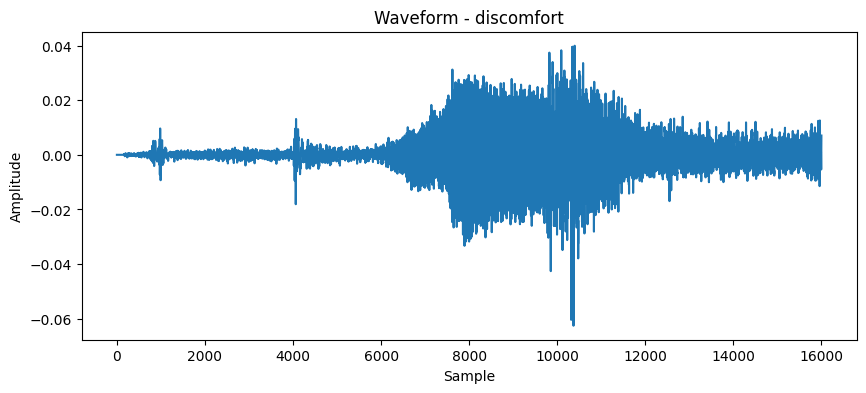

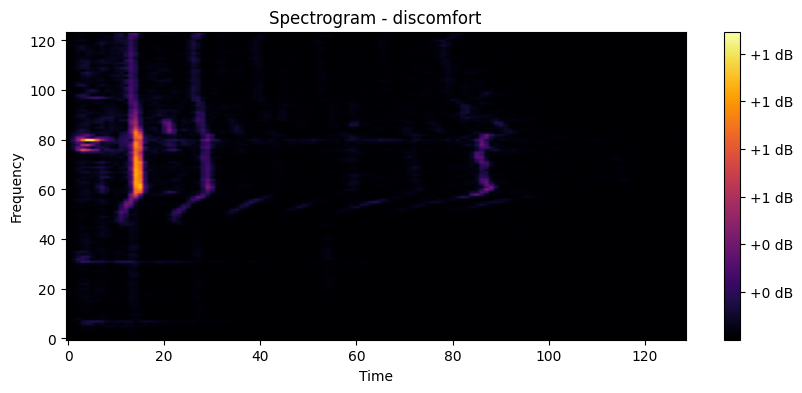

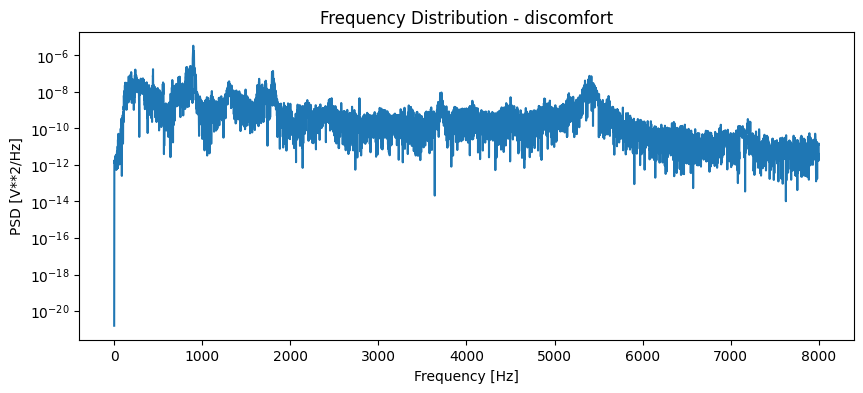

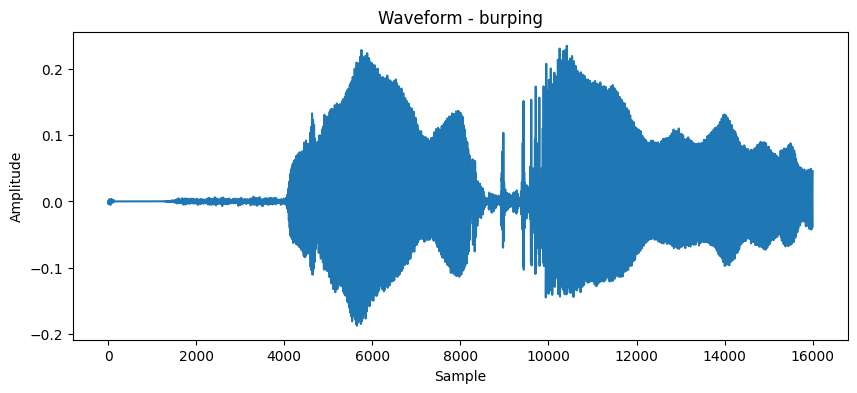

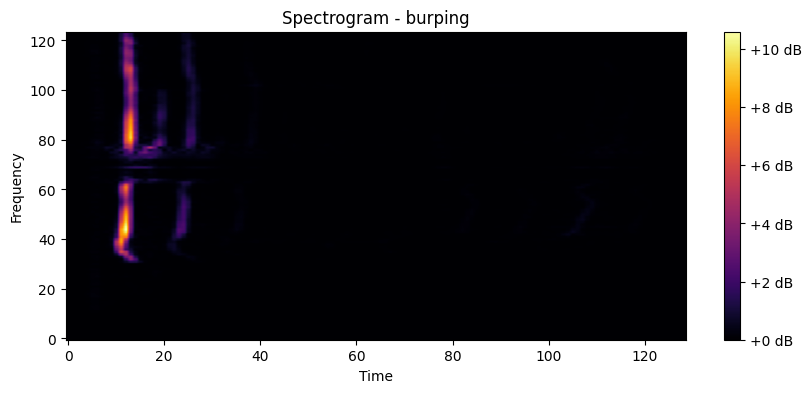

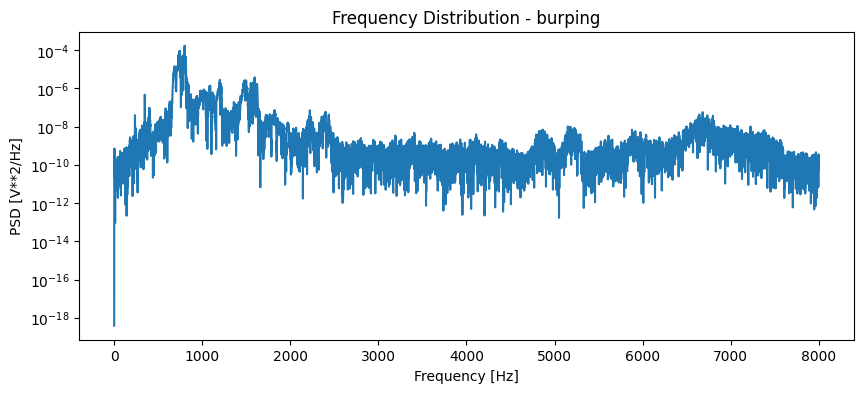

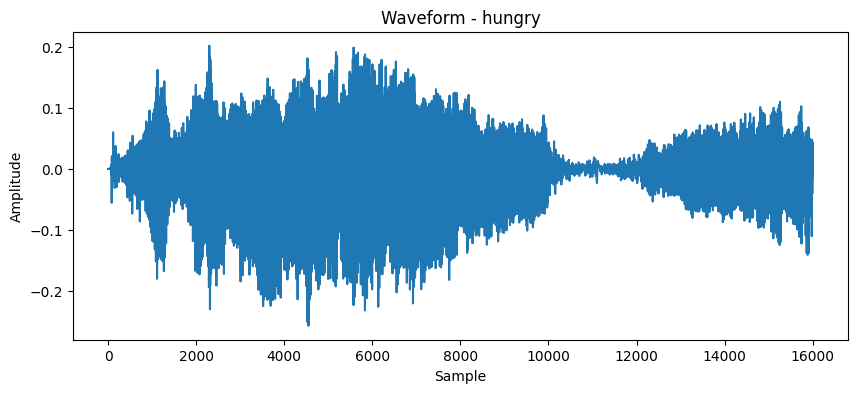

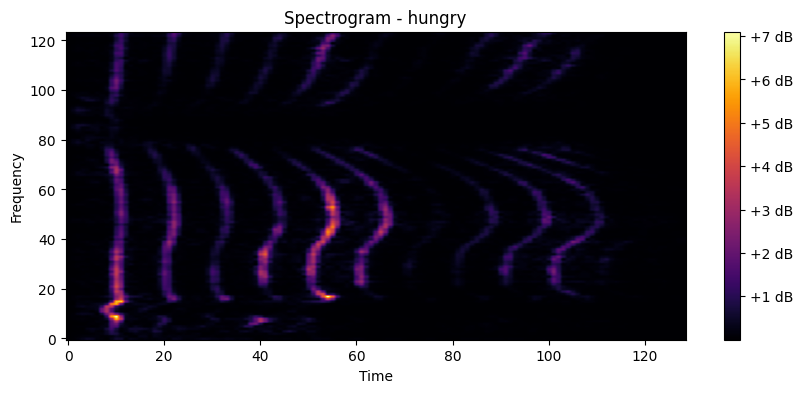

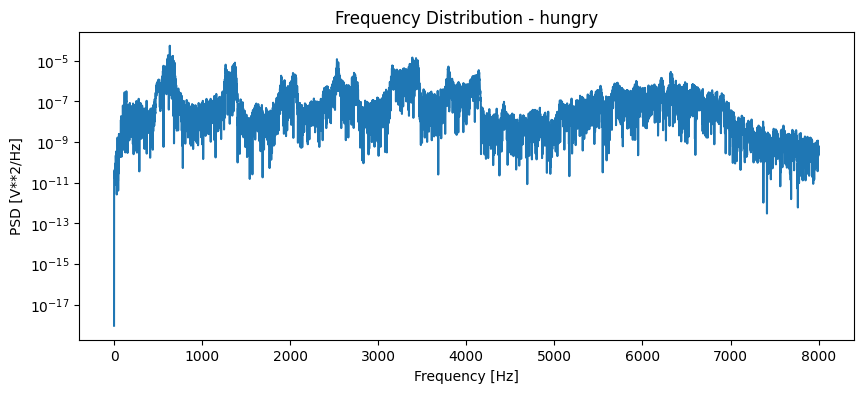

In [55]:
for audio, label in train_set.take(1):
    for i in range(3):  # Plot the first 3 examples
        waveform = audio[i].numpy()
        label_str = label_names[label[i].numpy()]

        # Plot Waveform
        plot_waveform(waveform, title=f'Waveform - {label_str}')

        # Generate and Plot Spectrogram
        spectrogram = get_spectogram(waveform).numpy()
        spectrogram = np.squeeze(spectrogram)  # Remove channel dimension
        plot_spectrogram(spectrogram, title=f'Spectrogram - {label_str}')

        # Plot Frequency Distribution
        plot_frequency_distribution(waveform, sr=16000, title=f'Frequency Distribution - {label_str}')

In [56]:
train_set_spec = make_spectogram_ds(train_set).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_set_spec = make_spectogram_ds(val_set).cache().prefetch(tf.data.AUTOTUNE)
test_set_spec = make_spectogram_ds(test_set).cache().prefetch(tf.data.AUTOTUNE)

In [57]:
for example_case, example_case_label in train_set_spec.take(1):
    break

In [58]:
input_shape = example_case.shape[1:]
num_label = len(cry_list)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_set_spec.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(num_label)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)       

In [59]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_set_spec,
    validation_data=val_set_spec,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=3, verbose=3)
)

Epoch 1/10
23/23 [==============================] - 2s 40ms/step - loss: 1.0943 - accuracy: 0.7896 - val_loss: 0.4988 - val_accuracy: 0.9070
Epoch 2/10
23/23 [==============================] - 1s 29ms/step - loss: 0.7276 - accuracy: 0.8251 - val_loss: 0.4542 - val_accuracy: 0.9070
Epoch 3/10
23/23 [==============================] - 1s 29ms/step - loss: 0.6772 - accuracy: 0.8279 - val_loss: 0.4578 - val_accuracy: 0.9070
Epoch 4/10
23/23 [==============================] - 1s 29ms/step - loss: 0.6514 - accuracy: 0.8361 - val_loss: 0.4951 - val_accuracy: 0.9070
Epoch 5/10
23/23 [==============================] - 1s 30ms/step - loss: 0.5341 - accuracy: 0.8579 - val_loss: 0.5123 - val_accuracy: 0.9070
Epoch 5: early stopping


In [61]:
model.save('cry_classification_model.h5')

In [62]:
ctr=0
for i , (spectogram, label) in enumerate(test_set_spec):
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    orig_label = label_names[label.numpy()]
    pred_label = [label_names[idx] for idx in pred_label_idx]
    for j, label in enumerate(orig_label):
        ctr+=1
        print(f'Data-{ctr}: label: {label} -> predicted: {pred_label[j]}') 
    

1/1 [==============================] - 0s 85ms/step
Data-1: label: hungry -> predicted: hungry
Data-2: label: hungry -> predicted: hungry
Data-3: label: hungry -> predicted: hungry
Data-4: label: hungry -> predicted: hungry
Data-5: label: hungry -> predicted: hungry
Data-6: label: tired -> predicted: hungry
Data-7: label: hungry -> predicted: hungry
Data-8: label: hungry -> predicted: hungry
Data-9: label: hungry -> predicted: hungry
Data-10: label: hungry -> predicted: hungry
Data-11: label: hungry -> predicted: hungry
Data-12: label: hungry -> predicted: hungry
Data-13: label: hungry -> predicted: hungry
Data-14: label: hungry -> predicted: hungry
Data-15: label: hungry -> predicted: hungry
Data-16: label: hungry -> predicted: hungry
1/1 [==============================] - 0s 26ms/step
Data-17: label: hungry -> predicted: hungry
Data-18: label: hungry -> predicted: hungry
Data-19: label: hungry -> predicted: hungry
Data-20: label: hungry -> predicted: hungry
Data-21: label: discomfort

In [63]:
test_result = model.evaluate(test_set_spec, return_dict=True)
accuracy = test_result['accuracy']
print(f"Accuracy = {round(accuracy * 100, 2)}%")

3/3 [==============================] - 0s 6ms/step - loss: 0.9773 - accuracy: 0.8333
Accuracy = 83.33%


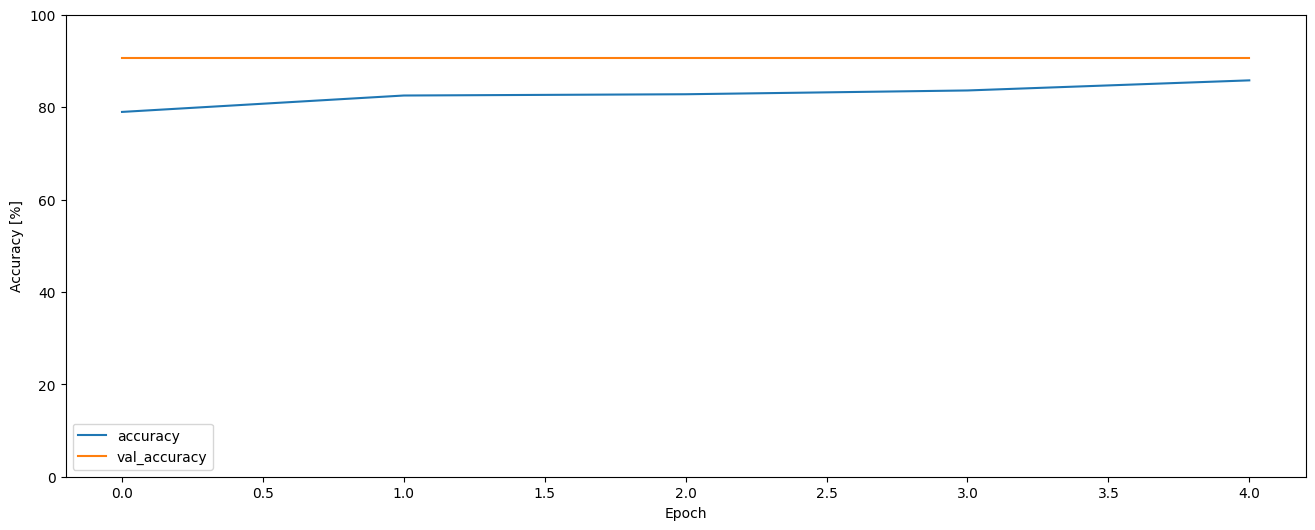

In [64]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

In [65]:
y_true = []
y_pred = []

for spectogram, label in test_set_spec:
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    y_true.extend(label.numpy())
    y_pred.extend(pred_label_idx)

y_true_names = [label_names[idx] for idx in y_true]
y_pred_names = [label_names[idx] for idx in y_pred]

precision = precision_score(y_true_names, y_pred_names, average='weighted')
recall = recall_score(y_true_names, y_pred_names, average='weighted')

print(f"Precision = {round(precision * 100, 2)}%")
print(f"Recall = {round(recall * 100, 2)}%")
print("Classification Report:")
print(classification_report(y_true_names, y_pred_names, labels=label_names))

1/1 [==============================] - 0s 20ms/step
Precision = 69.44%
Recall = 83.33%
Classification Report:
              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         0
     burping       0.00      0.00      0.00         0
  discomfort       0.00      0.00      0.00         5
      hungry       0.83      1.00      0.91        40
       tired       0.00      0.00      0.00         3

   micro avg       0.83      0.83      0.83        48
   macro avg       0.17      0.20      0.18        48
weighted avg       0.69      0.83      0.76        48



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Confusion Matrix:


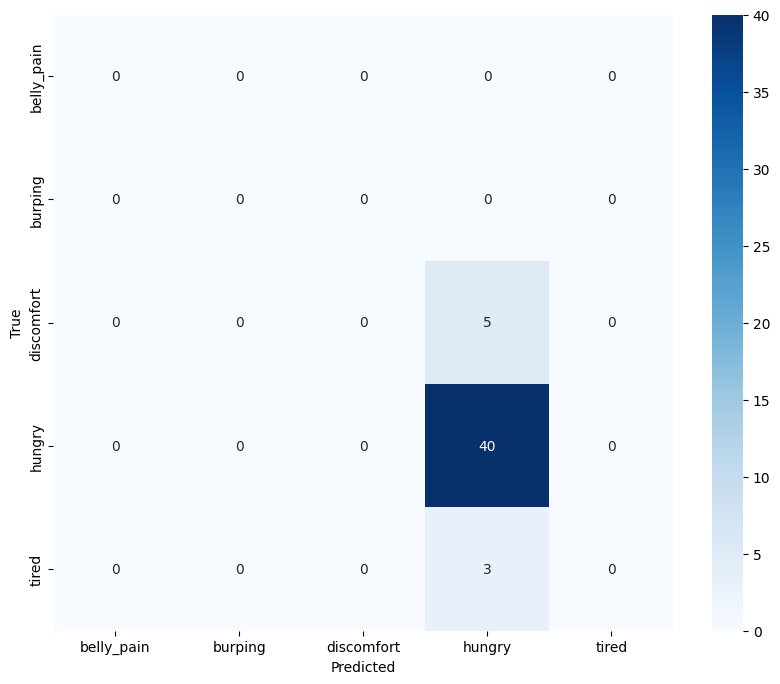

In [66]:
print("Confusion Matrix:")
cm = confusion_matrix(y_true_names, y_pred_names, labels=label_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()